# Brief Explanation

**Brief Explanation:**

To work, you must have an unchanged copy of the Google Form responses sheet saved to your My Drive.


---


Familiarize yourself with the code. Look through and make sure you have an idea of how it works.


---


Type the the name of the survey response file in the cell below. Run the cell.
 Run the load in folder.  


---


To execute code, click the triangle in a circle that appears when hovering over the bracket box [ ] to the left of the italicized "cells hidden" message. Individual cells can also be run by pressing shift enter.




---

You will have to run the functions in the preceding folders to use later analysis. Run the function folder but you don't have to run the main.


---


Despite response validation, layers of error handling, and several iterations of testing, you may well get nonsensical results or run-time errors. Compile time errors are even possible. Most immediately, survey respondants may not have followed directions or perhaps they made typos. Encountering problems in the Routing Analysis may be due to the OSRM API usage limits.


---


If you run into any problems, or are just curious, please see our Documentation. Futhermore, as you will find, the code is commented throughout. Lastly, I encourage you to implement your own fixes and improvements, and please feel free to share them with me at js0735@princeton.edu.

# Functions

#### Load-in and Access


In [1]:
import pandas as pd
from google.colab import drive

def load_in(file_name):

  #to import your comma seperated value (.csv file) data frame from google drive

  drive.mount('/content/drive', force_remount=True)

  path = '/content/drive/MyDrive/'
  file = path + file_name
  df = pd.read_csv(file, header=0)

  new_headers = ['Time', 'Level', 'Department', "Years w/ Company", "Lat and Long", "Pincode", "Commute Time", "Commute Method", "Age", "Gender", "Marraige", "Children", "Residence", "Daycare Preference", "Shifting Preference", "Pincode Preference", "Salary / WFO Preference"]


  df.columns = new_headers
  return df

In [2]:
def get_column_number(column_name, df):
    try:
        column_number = df.columns.get_loc(column_name)
        return column_number
    except KeyError:
        print(f"Error: Column '{column_name}' not found in the DataFrame.")
        return None

In [3]:
def get_value(df,column,row):
  return df[list(df.keys())[column]][row]

#### Scatter Plot and Heat Map

##### Convert to Numeric

In [38]:
def numeric(df):
  num_dict = {'Man' : 1, "Woman" : 0, "Yes" : 1, "No" : 0, 'Non executive':0,'Mid level executive or manager':1,'Upper level executive, VP, etc.':2}
  df_copy = df.copy()
  columns = ["Gender", "Marraige","Level"]

  for column in columns:
        if column in df_copy.columns:
            df_copy[column] = df_copy[column].replace(num_dict)
        else:
            raise KeyError(f"Column '{column}' not found in DataFrame")

  columnnums_to_drop = [0,2,4,5,7,12,15]
  columns_to_drop = []

  for colnum in columnnums_to_drop:
    columns_to_drop.append(list(df.keys())[colnum])

  # Drop the specified columns

  df_copy.drop(columns=columns_to_drop, inplace=True)
  return df_copy



In [5]:
def non_drop_numeric(df):
  num_dict = {'Man' : 1, "Woman" : 0, "Yes" : 1, "No" : 0, 'Non executive':1, 'Mid level executive or manager':2,'Upper level executive, VP, etc.':3}
  df_copy = df.copy()
  columns = ["Gender", "Marraige","Level"]

  for column in columns:
        if column in df_copy.columns:
            df_copy[column] = df_copy[column].replace(num_dict)
        else:
            raise KeyError(f"Column '{column}' not found in DataFrame")

  return df_copy

##### Pairplot and Heatmap

In [6]:
import seaborn as sns
def pairplot(num_df):
  sns.pairplot(num_df)

In [7]:
from matplotlib import rcParams
def heatmap(num_df):
  rcParams['figure.figsize'] = 8,8
  correlation_matrix = num_df.corr().round(2)
  sns.heatmap(data=correlation_matrix, annot=True)

#### Bar Grapher

##### Helper

In [8]:
### Helper function to the bar grapher

def filter_and_calculate_average_target(df, target_dict, target_val):
    # Create a boolean mask for filtering
    mask = pd.Series(True, index=df.index)

    # Apply filters for each column and target entry
    for column, target in target_dict.items():
        mask &= df[column] == target

    # Filter the DataFrame
    filtered_df = df[mask]

    # Calculate average effective rent
    avg_target_val = filtered_df[target_val].mean()
    count = filtered_df[target_val].count()

    return round(avg_target_val,2), count

##### Basic Bargraph

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def make_bargraph(df, column, target_val):
    # Calculate averages and counts
    averages = []
    counts = []
    categories = []
    unique_in_column = df[column].unique()

    for category in unique_in_column:
        condition = {column: category}
        avg, count = filter_and_calculate_average_target(df, condition, target_val)
        averages.append(avg)
        counts.append(count)
        categories.append(category)

    # Create a DataFrame from the results
    result_df = pd.DataFrame({column: categories, 'Average': averages, 'Count': counts})

    # Sort the DataFrame if the category is numerical
    if pd.api.types.is_numeric_dtype(result_df[column]):
        result_df = result_df.sort_values(by=column)

    # Create the plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=column, y='Average', data=result_df)

    # Add average and count labels on each bar
    for i, bar in enumerate(ax.patches):
        height = bar.get_height()
        avg = result_df['Average'].iloc[i]
        count = result_df['Count'].iloc[i]

        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'Avg: {avg:.2f}\nCount: {count}',
                ha='center', va='bottom', fontsize=8)




    # Define your custom color palette with hex values
    custom_palette = {
        'primary': '#1ececa',    # Example: indiqube light blue
        'secondary': '#0b109f',  # Example: indiqube dark blue
        'accent': '#0000fa'      # Example: another blue
    }

    # Set the style
    sns.set_style("whitegrid")

    # Set the custom color palette
    sns.set_palette(list(custom_palette.values()))

    # If you want to set specific elements to use specific colors:
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_palette.values())

    # Customize the plot
    plt.title(f'Average {target_val} by {column} (with counts)')
    plt.xlabel(column)
    plt.ylabel(f'Average {target_val}')

    # Rotate x-axis labels if there are many categories
    if len(unique_in_column) > 10:
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Note: This function assumes filter_and_calculate_avg_target is defined elsewhere
# and returns both the average and the count

##### Location Specific Bargraph

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def make_bargraph_for_this_center(df, column, target_val, location):
    # Calculate averages and counts
    averages = []
    counts = []
    categories = []
    unique_in_column = df[column].unique()

    for category in unique_in_column:
        condition = {column: category}
        avg, count = filter_and_calculate_average_target(df, condition, target_val)
        averages.append(avg)
        counts.append(count)
        categories.append(category)

    # Create a DataFrame from the results
    result_df = pd.DataFrame({column: categories, 'Average': averages, 'Count': counts})

    # Sort the DataFrame if the category is numerical
    if pd.api.types.is_numeric_dtype(result_df[column]):
        result_df = result_df.sort_values(by=column)

    # Create the plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=column, y='Average', data=result_df)

    # Add average and count labels on each bar
    for i, bar in enumerate(ax.patches):
        height = bar.get_height()
        avg = result_df['Average'].iloc[i]
        count = result_df['Count'].iloc[i]

        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'Avg: {avg:.2f}\nCount: {count}',
                ha='center', va='bottom', fontsize=8)




    # Define your custom color palette with hex values
    custom_palette = {
        'primary': '#1ececa',    # Example: indiqube light blue
        'secondary': '#0b109f',  # Example: indiqube dark blue
        'accent': '#0000fa'      # Example: another blue
    }

    # Set the style
    sns.set_style("whitegrid")

    # Set the custom color palette
    sns.set_palette(list(custom_palette.values()))

    # If you want to set specific elements to use specific colors:
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_palette.values())

    # Customize the plot
    plt.title(f'Average {target_val} by {column} (with counts)' + location)
    plt.xlabel(column)
    plt.ylabel(f'Average {target_val}')

    # Rotate x-axis labels if there are many categories
    if len(unique_in_column) > 10:
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Note: This function assumes filter_and_calculate_avg_target is defined elsewhere
# and returns both the average and the count

##### Bar Grapher with UI

In [11]:
import ipywidgets as widgets
from IPython.display import display

def interactive_bargraph(combined_df):
    num_df = non_drop_numeric(combined_df)

    def update_graph(categories, value, for_title):
        make_bargraph_for_this_center(num_df, categories, value, for_title)

    categories_widget = widgets.Dropdown(
    options=list(combined_df.columns),  # Use columns instead of keys
    value=list(combined_df.columns)[2],  # Select the first column as the default value
    description='Categories:'
    )

    value_widget = widgets.Dropdown(
        options=['Years w/ Company', 'Level','Commute Time', 'Age', 'Gender',
       'Marraige', 'Children', 'Daycare Preference',
       'Shifting Preference', 'Pincode Preference', 'Salary / WFO Preference', 'Indiqube Rating', 'Frequency of app',
       'Usefulness of app','time',
       'distance'],  # Add more options as needed
        value='Age',
        description='Value:'
    )

    for_title_widget = widgets.Text(
        value=' for Geographic Center',
        description='Title:',
        disabled=False
    )

    output = widgets.Output()

    def on_change(change):
        output.clear_output()
        with output:
            update_graph(categories_widget.value, value_widget.value, for_title_widget.value)

    categories_widget.observe(on_change, names='value')
    value_widget.observe(on_change, names='value')
    for_title_widget.observe(on_change, names='value')

    vbox = widgets.VBox([categories_widget, value_widget, for_title_widget, output])
    display(vbox)

    # Initial graph display
    with output:
        update_graph(categories_widget.value, value_widget.value, for_title_widget.value)

#### Standarize Locations

In [12]:
def parse_number_pair(string):
    try:
        # Split the string at the comma
        num1, num2 = string.split(',')
        # Convert both parts to floats and return as a tuple
        return (float(num1.strip()), float(num2.strip()))
    except ValueError:
        # If there's an error in parsing, return None or raise an exception
        # return None  # or
        raise ValueError("Invalid format")

In [13]:
def get_points(df):
  points = list(df[list(df.keys())[4]])

  latlongs = []
  for point in points:
    latlongs.append(parse_number_pair(point))

  lat = 0
  longi = 0
  for latlong in latlongs:
    lat += latlong[0]
    longi += latlong[1]

  lat = lat / len(latlongs)
  longi = longi / len(latlongs)

  geocenter = (lat,longi)

  return latlongs, geocenter

#### OSRM Routing

In [14]:
# Gets route data from OSRM
# The function returns geometry, time, distance
# geometry is a dict with 'coordinates' as the key and a list of lat-long points as the value
# time is in seconds, and accounts for average traffic and turns but not time of day
# distance is in meters

import requests
def get_route_info(start, end):
  # Format start and end points
  start_str = f"{start[1]},{start[0]}"
  end_str = f"{end[1]},{end[0]}"

  # Combine start and end into a single string
  waypoints_str = f"{start_str};{end_str}"

  url = f"http://router.project-osrm.org/route/v1/driving/{waypoints_str}?geometries=geojson"


  # Make the request
  response = requests.get(url)
  if response.status_code != 200:
      raise Exception(f"Error: Received response code {response.status_code} from OSRM server")

  data = response.json()


  if 'routes' in data:
      routeinfo = data['routes']

      if routeinfo and 'geometry' in routeinfo[0]:
          geometry = routeinfo[0]['geometry']
          time = routeinfo[0]['duration']
          distance = routeinfo[0]['distance']
          if not distance:
            print("none")

      else:
          print("response does not contain info")
  else:
      print("No 'routes' key in data")

  return geometry, time, distance

In [15]:
# returns a list of dicts.
# each dict contains geometry, time, and distance

def get_route_infos(df,gathering_point):
  points, geocenter = get_points(df)

  route_infos = []

  for point in points:
    geometry, time, distance = get_route_info(point, gathering_point)
    route_info = {
        'geometry': geometry,
        'time': time,
        'distance': distance
    }
    route_infos.append(route_info)

  return route_infos

In [16]:
# returns a list of dicts.
# each dict contains geometry, time, and distance

def get_route_infos_from_list(points,gathering_point):

  route_infos = []

  for point in points:
    geometry, time, distance = get_route_info(point, gathering_point)
    route_info = {
        'geometry': geometry,
        'time': time,
        'distance': distance
    }
    route_infos.append(route_info)

  return route_infos

In [17]:
def create_routes_dataframe(list_of_dicts):
    # Create the DataFrame directly from the list of dictionaries
    df = pd.DataFrame(list_of_dicts)

    # Ensure the DataFrame has the desired columns in the correct order
    desired_columns = ['geometry', 'time', 'distance']
    df = df.reindex(columns=desired_columns)

    return df

#### Commute Analysis

##### Define Assumptions

In [18]:
def define_ratios(): # these dictionaries are my own estimates, feel free to change
  ratios = {
    "Two wheeler EV": 0.02,
    "Two wheeler non EV": 0.04,
    "Two Wheeler EV": 0.02,
    "Two Wheeler non EV": 0.04,
    "Personal car EV": 0.03,
    "Personal car non EV": 0.12,
    "Personal Car EV": 0.03,
    "Personal Car non EV": 0.12,
    "Bus": 0.05,
    "Metro": 0.03,
    "Auto": 0.04,
    "Namma Yatri, Uber, Rapido, etc.": 0.12
}
  ratios["Combination of these"] = sum(ratios.values()) / len(ratios.values())

  uncertainties = {
    "Two wheeler EV": 0.003,
    "Two wheeler non EV": 0.005,
    "Two Wheeler EV": 0.003,
    "Two Wheeler non EV": 0.005,
    "Personal car EV": 0.004,
    "Personal car non EV": 0.013,
    "Personal Car EV": 0.004,
    "Personal Car non EV": 0.013,
    "Bus": 0.006,
    "Metro": 0.004,
    "Auto": 0.004,
    "Namma Yatri, Uber, Rapido, etc.": 0.012
}
  uncertainties["Combination of these"] = ratios["Combination of these"] / 10

  return ratios, uncertainties

##### Make Calculations

In [19]:
def safe_round(value, decimals=2):
    """
    Safely round a value to the specified number of decimal places.
    If the value is not a number, return it unchanged.
    """
    try:
        return round(float(value), decimals)
    except (TypeError, ValueError):
        return value

In [20]:
def quick_calcs(combined_df, multiplier):
  methods = list(combined_df['Commute Method'])
  times = list(combined_df['time'])
  distances = list(combined_df['distance'])

  go_there_come_back = 2
  total_time = sum(times) * go_there_come_back * multiplier
  mean_time = sum(times) * multiplier / len(times)
  median_time = statistics.median(times) * multiplier

  total_distance = sum(distances) * go_there_come_back
  mean_distance = sum(distances) / len(distances)
  median_distance = statistics.median(distances)

  return methods, distances, total_time, mean_time, median_time, total_distance, mean_distance,median_distance

In [21]:
# Total, Mean, Median : Time
# Total, Mean, Median : Distance
# Total + Error Emissions

# See the assumption made throught out, including estimations for kgs per km for modes of transport and 50, 5-day work weeks each year with round trip commutes each work day
# also the traffic multiplier in Bengaluru during rush hour seems to be about x2 to the OSRM optimal times, so that's what I used
# that multiplier also applies to emissions estimates because it accounts for idling.

import statistics
import math

def commute_analysis(combined_df, office_name,multiplier=3):

  # SET
  round_by = 2

  # SET THESE
  annual_factor = 50 * 5 * 2  # 50 weeks, 5 days a week, 2 ways per day
  traffic_multiplier = multiplier

  ratios, uncertainties = define_ratios()

  methods, distances, sum_daily_time, mean_time, median_time, total_distance, mean_distance, median_distance = quick_calcs(combined_df,multiplier)

  total_emissions_everyone_one_way = 0
  error_margin  = 0

  #annual_emissions_standard_error = compute_annual_emmissions_standard_error(distances, methods, ratios, traffic_multiplier, annual_factor)

  i = 0
  for distance in distances:
    total_emissions_everyone_one_way += (distance / 1000) * (ratios[methods[i]] * traffic_multiplier)
    error_margin += (distance / 1000) * (uncertainties[methods[i]] * traffic_multiplier)
    i += 1

  data = {
      "For " + office_name: [
          sum_daily_time / 60 / 60,
          mean_time / 60,
          median_time / 60,
          total_distance / 1000,
          mean_distance / 1000,
          median_distance / 1000,
          total_emissions_everyone_one_way * 2 * annual_factor,
          error_margin * 2 * annual_factor
      ]
  }

  # Round all values to r decimal places
  data["For " + office_name] = [safe_round(num, round_by) for num in data["For " + office_name]]

  title = {
      "Measure": [
          "total time spend commuting (hours e/ day)",
          "mean commute time (minutes)",
          "median commute time (minutes)",
          "total distance (km a/ day)",
          "mean commute distance (km)",
          "median commute distance (km)",
          "total emissions (kgs e/ year)",
          "emissions error margin (kgs e/ year)"
      ]
  }

  # Create DataFrame
  df = pd.DataFrame({**title, **data})

  return df

##### Error Propogation

This does not work and I do not know why.

In [22]:
# route accuracy must be intpreted as what to multiply a distance by to get the standard error of the distribution of routes of that distance
# 1/4 seems good

# Bengaluru's rush hour traffic multiplier seems to be around 2 (both time and emissions per km traveled)
# in fact, emissions per km traveled is often scaled even more than time is by traffic, as braking and acceleration burns more fuel than cruising

import math

def compute_everyone_oneway_emissions_SE(distances, ratios, methods, traffic, route_error_fraction):
    total_variance = 0
    for i in range(len(distances)):
        distance = float(distances[i])
        method = float(ratios[methods[i]])
        distance_se = (distance / 1000) * route_error_fraction

        one_way_one_person_se = distance_se * method * traffic
        total_variance += math.pow(one_way_one_person_se, 2)

    print(total_variance)

    return math.sqrt(total_variance)

In [23]:
def compute_annual_emmissions_standard_error(distances, methods, ratios, traffic, annual_factor,route_error_fraction=.1):
    everyone_oneway_emissions_SE = compute_everyone_oneway_emissions_SE(distances, ratios, methods, traffic, route_error_fraction)

    # Assuming independence. sqrt2 is for both ways

    annuel_commutes_se = math.sqrt(annual_factor) * everyone_oneway_emissions_SE * math.sqrt(2)

    return annuel_commutes_se

##### Data Frame Output

In [24]:
import pandas as pd
def create_the_comparison_df(resultA, resultB):

  shared_column = resultA.columns[0]
  result = pd.concat([resultA, resultB.drop(columns=[shared_column])], axis=1)

  result = add_difference_column(result)
  result = update_bottom_right(result)

  return result

def add_difference_column(df):
    # Assuming the DataFrame has at least 3 columns
    df['Difference'] = df.iloc[:, 2] - df.iloc[:, 1]
    return df

def update_bottom_right(df):
    # Get the last row and last three columns
    last_row = df.iloc[-1, -3:]

    # Calculate the average of the two leftmost values
    average = np.mean(last_row.iloc[:2])

    # Update the rightmost value with the calculated average
    df.iloc[-1, -1] = average

    return df

#### Clustering Algorithms

##### K-Means

In [25]:
### non-weighted Kmeans clustering

import numpy as np
from sklearn.cluster import KMeans

def Kmeans(codes):
  array_2d = np.array([np.array(pair) for pair in codes])
  kmeans = KMeans(n_clusters=2, random_state=3, init='k-means++')
  kmeans.fit(codes)
  labels = kmeans.labels_
  labels = list(labels)
  centroids = kmeans.cluster_centers_

  return labels, centroids


##### Weighted K-Means

In [26]:
def standard_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

In [27]:
# Weighted K-means clustering algorithm
# an adapted Claude AI function:

import numpy as np
from typing import List, Tuple, Callable

def claudes_weighted_kmeans(
    points: List[Tuple[float, float]],
    weights: List[float],
    n_clusters: int,
    max_iterations: int,
    n_repetitions: int,
    distance_func: Callable[[Tuple[float, float], Tuple[float, float]], float]
) -> Tuple[List[int], List[Tuple[float, float]]]:

    points = np.array(points)
    weights = np.array(weights)

    best_labels = None
    best_centroids = None
    best_inertia = float('inf')

    for _ in range(n_repetitions):
        # Randomly initialize centroids
        centroids = points[np.random.choice(len(points), n_clusters, replace=False)]

        for _ in range(max_iterations):
            # Assign points to nearest centroid
            distances = np.array([[distance_func(point, centroid) for centroid in centroids] for point in points])
            labels = np.argmin(distances, axis=1)

            # Update centroids
            new_centroids = []
            for i in range(n_clusters):
                cluster_points = points[labels == i]
                cluster_weights = weights[labels == i]
                if len(cluster_points) > 0:
                    new_centroids.append(np.average(cluster_points, axis=0, weights=cluster_weights))
                else:
                    new_centroids.append(centroids[i])

            new_centroids = np.array(new_centroids)

            # Check for convergence
            if np.all(centroids == new_centroids):
                break

            centroids = new_centroids

        # Calculate inertia (weighted sum of squared distances)
        inertia = sum(weights[i] * distance_func(points[i], centroids[labels[i]])**2 for i in range(len(points)))

        # Update best solution if current solution is better
        if inertia < best_inertia:
            best_inertia = inertia
            best_labels = labels
            best_centroids = centroids

    return best_labels.tolist(), best_centroids.tolist()

####  Plotting Folium Maps

##### Plot Employees

In [28]:
import folium

def plot_employees(df,coloring, pop_up, description, map_theme):

  latlongs, center = get_points(df)

  if (map_theme == 'clean'):
    # URL for the custom tile layer
    tile_url = 'http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png'

    # Attribution for the custom tile layer
    tile_attribution = 'Map tiles by CartoDB, under CC BY 3.0. Data by OpenStreetMap, under ODbL.'

    # Create a map with the custom tile layer
    mymap = folium.Map(location=center, zoom_start=12, width='100%', height='100%', tiles=tile_url, attr=tile_attribution)

  else:
     mymap = folium.Map(location=center, zoom_start=12, width='100%', height='100%')

  popup_column = get_column_number(pop_up, df)
  description_column = get_column_number(description, df)
  color_column = get_column_number(coloring, df)

  # Get unique categories from the target column
  categories = df[coloring].unique()

  # List of predefined colors
  colors = ['pink', 'cadetblue', 'darkgreen', 'gray', 'darkblue', 'lightblue', 'darkpurple',
              'red', 'lightgray', 'beige', 'green', 'blue', 'darkred', 'black', 'purple',
              'orange', 'lightred', 'lightgreen',]

  # Create a color map for categories
  # Ensure we have enough colors
  if len(categories) > len(colors):
      raise ValueError(f"Not enough unique colors for {len(categories)} categories. Only {len(colors)} colors available.")

  # Create a color map for categories
  selected_colors = random.sample(colors, len(categories))
  color_map = dict(zip(categories, selected_colors))

  # Add points to the map
  row = 0
  for latlong in latlongs:
    folium.Marker(
        location=latlong,
        popup= get_value(df, popup_column, row),
        tooltip= get_value(df, description_column, row),
        icon=folium.Icon(color=color_map[get_value(df, color_column, row)])
    ).add_to(mymap)
    row += 1

    # Add a legend
    legend_html = '''
    <div style="
        position: fixed;
        top: 10px;
        right: 10px;
        width: 150px;
        background-color: rgba(184, 242, 243, 0.8);
        border: 2px solid grey;
        z-index: 9999;
        font-size: 14px;
        padding: 10px;
        border-radius: 5px;
    ">
        <b>Legend</b><br>
    '''
  for category, color in color_map.items():
      legend_html += f"&nbsp;<i class='fa fa-map-marker fa-2x' style='color:{color}'></i>&nbsp;{category}<br>"
  legend_html += '</div>'
  mymap.get_root().html.add_child(folium.Element(legend_html))


  return mymap


##### Plot Employees UI

In [29]:
### User Interface to show what's available to plot
import ipywidgets as widgets
from IPython.display import display

def create_employee_map_ui(df, plot_employees_func):
    # Define options for each dropdown
    coloring_options = list(df.keys())
    popup_options = list(df.keys())
    description_options = list(df.keys())
    theme_options = ["standard", "clean"]

    # Create dropdown widgets
    coloring_dropdown = widgets.Dropdown(options=coloring_options, description='Coloring:', value='Level')
    popup_dropdown = widgets.Dropdown(options=popup_options, description='Pop-up:', value='Gender')
    description_dropdown = widgets.Dropdown(options=description_options, description='Description:', value='Age')
    theme_dropdown = widgets.Dropdown(options=theme_options, description='Theme:', value='clean')

    # Create output widget to display the map
    output = widgets.Output()

    # Function to update the map
    def update_map(*args):
        with output:
            output.clear_output(wait=True)
            m = plot_employees_func(
                df,
                coloring_dropdown.value,
                description_dropdown.value,
                popup_dropdown.value,
                theme_dropdown.value
            )
            display(m)

    # Observe changes for all dropdowns
    coloring_dropdown.observe(update_map, names='value')
    popup_dropdown.observe(update_map, names='value')
    description_dropdown.observe(update_map, names='value')
    theme_dropdown.observe(update_map, names='value')

    # Create a vertical box layout for dropdowns
    dropdown_vbox = widgets.VBox([coloring_dropdown, popup_dropdown, description_dropdown, theme_dropdown])

    # Create a vertical box layout for both dropdowns and output
    main_vbox = widgets.VBox([dropdown_vbox, output])

    # Initial map update
    update_map()

    return main_vbox

##### Plot Routes

In [30]:
def add_routes(mymap, route_geometries,col):
    # Add polylines for each route
    for route_geometry in route_geometries:
        folium.PolyLine(
            locations=[list(reversed(coord)) for coord in route_geometry],
            color=col,
            weight=5
        ).add_to(mymap)

    return mymap

In [31]:
def create_route_map(routes_df, center, plotpoint, map_theme):

  if (map_theme == 'clean'):
    # URL for the custom tile layer
    tile_url = 'http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png'

    # Attribution for the custom tile layer
    tile_attribution = 'Map tiles by CartoDB, under CC BY 3.0. Data by OpenStreetMap, under ODbL.'

    # Create a map with the custom tile layer
    mymap = folium.Map(location=center, zoom_start=12, tiles=tile_url, attr=tile_attribution)

  else:
    mymap = folium.Map(location=center, zoom_start=12)

  routes = []

  for index, row in routes_df.iterrows():

    point = (row['geometry']['coordinates'][0][1], row['geometry']['coordinates'][0][0])

    folium.Marker(location=point, popup=row['time'], icon=folium.Icon(color='blue')).add_to(mymap)

    routes.append(row['geometry']['coordinates'])

    mymap = add_routes(mymap,routes, "blue")


  folium.Marker(center, popup=f'center', icon=folium.Icon(color='red')).add_to(mymap)
  folium.Marker(plotpoint, popup=f'center', icon=folium.Icon(color='red')).add_to(mymap)

  return mymap

##### Plot Clusters

In [32]:
### Plot Clusters

import folium
def plot_clusters(points, center, labels, centroids, map_theme):

  array_2d = np.array([np.array(pair) for pair in points])

  if (map_theme == 'clean'):
    # URL for the custom tile layer
    tile_url = 'http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png'

    # Attribution for the custom tile layer
    tile_attribution = 'Map tiles by CartoDB, under CC BY 3.0. Data by OpenStreetMap, under ODbL.'

    # Create a map with the custom tile layer
    cluster_map = folium.Map(location=center, zoom_start=12, tiles=tile_url, attr=tile_attribution)

  else:
     cluster_map = folium.Map(location=center, zoom_start=12)



  colors = [
        'red', 'blue', 'green', 'purple', 'orange', 'darkred',
        'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
        'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
        'gray', 'black', 'lightgray'
    ]


  # Add markers for each point
  for i in range(len(array_2d)):
      folium.Marker(
          location=array_2d[i],
          popup=f'employee{i}',
          icon=folium.Icon(color=colors[labels[i]])
      ).add_to(cluster_map)

  # Add markers for centroids
  for i in range(len(centroids)):
      folium.Marker(centroids[i], popup=f'Centroid {i}', icon=folium.Icon(color='black')).add_to(cluster_map)

  # Display the map
  return cluster_map

##### Plot by Category

In [33]:
import folium
from folium.plugins import MarkerCluster
import random

def plot_by_category(df, target_column, geocenter, zoom_start,map_theme):
    location_column = 'Lat and Long'

    # Create a map
    if (map_theme == 'clean'):
      # URL for the custom tile layer
      tile_url = 'http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png'

      # Attribution for the custom tile layer
      tile_attribution = 'Map tiles by CartoDB, under CC BY 3.0. Data by OpenStreetMap, under ODbL.'

      # Create a map with the custom tile layer
      m = folium.Map(location=center, zoom_start=2, width='100%', height='100%', tiles=tile_url, attr=tile_attribution)

    else:
      m = folium.Map(location=geocenter, zoom_start=12)


    # Create a MarkerCluster
    # marker_cluster = MarkerCluster().add_to(m)

    # Get unique categories from the target column
    categories = df[target_column].unique()

    # List of predefined colors
    colors = ['pink', 'cadetblue', 'darkgreen', 'gray', 'darkblue', 'lightblue', 'darkpurple',
              'red', 'lightgray', 'beige', 'green', 'blue', 'darkred', 'black', 'purple',
              'orange', 'lightred', 'lightgreen',]

    # Create a color map for categories
    # Ensure we have enough colors
    if len(categories) > len(colors):
        raise ValueError(f"Not enough unique colors for {len(categories)} categories. Only {len(colors)} colors available.")

    # Create a color map for categories
    selected_colors = random.sample(colors, len(categories))
    color_map = dict(zip(categories, selected_colors))

    # Dictionary to store sum of coordinates and count for each category
    category_coords = {cat: {'sum': [0.0, 0.0], 'count': 0} for cat in categories}

    # Add markers for each point
    for idx, row in df.iterrows():
        lat, lon = parse_number_pair(row[location_column])
        category = row[target_column]
        color = color_map[category]

        folium.Marker(
            location=[lat, lon],
            popup=f"{target_column}: {category}",
            icon=folium.Icon(color=color, icon='info-sign')
        ).add_to(m)

        # Update sum and count for category
        category_coords[category]['sum'][0] += lat
        category_coords[category]['sum'][1] += lon
        category_coords[category]['count'] += 1

    # Add center of mass markers for each category
    for category, data in category_coords.items():
        if data['count'] > 0:
            center_of_mass = [data['sum'][0] / data['count'], data['sum'][1] / data['count']]
            folium.Marker(
                location=center_of_mass,
                popup=f"Center of Mass for {category}",
                icon=folium.Icon(color=color_map[category], icon='star')
            ).add_to(m)

    # Add a legend
    legend_html = '''
    <div style="
        position: fixed;
        top: 10px;
        right: 10px;
        width: 150px;
        background-color: rgba(0, 255, 0, 0.8);
        border: 2px solid grey;
        z-index: 9999;
        font-size: 14px;
        padding: 10px;
        border-radius: 5px;
    ">
        <b>Legend</b><br>
    '''
    for category, color in color_map.items():
        legend_html += f"<i class='fa fa-map-marker' style='color:{color}'></i> {category}<br>"
    legend_html += '</div>'
    m.get_root().html.add_child(folium.Element(legend_html))

    return m

# User Interface

## Load In

In [34]:
surveyfilename = "Example_Responses_LOCUS.csv"

In [35]:
df = load_in(surveyfilename)


Mounted at /content/drive


In [36]:
df.head(2)

,Time,Level,Department,Years w/ Company,Lat and Long,Pincode,Commute Time,Commute Method,Age,Gender,Marraige,Children,Residence,Daycare Preference,Shifting Preference,Pincode Preference,Salary / WFO Preference
0,7/23/2024 12:30:11,Non executive,Marketing,0.25,"12.929219184155466, 77.62771079999999",NaN,30,Two wheeler EV,20,Man,No,0,PG,1,1,NaN,1
1,NaN,Non executive,IT,1.50,"12.950795517102389, 77.61704047253774",NaN,40,Two Wheeler EV,24,Man,No,0,PG,1,2,NaN,2


## Basic Tools

### Heatmap and Pairplot

In [39]:
num_df = numeric(df)
# num_df.head()

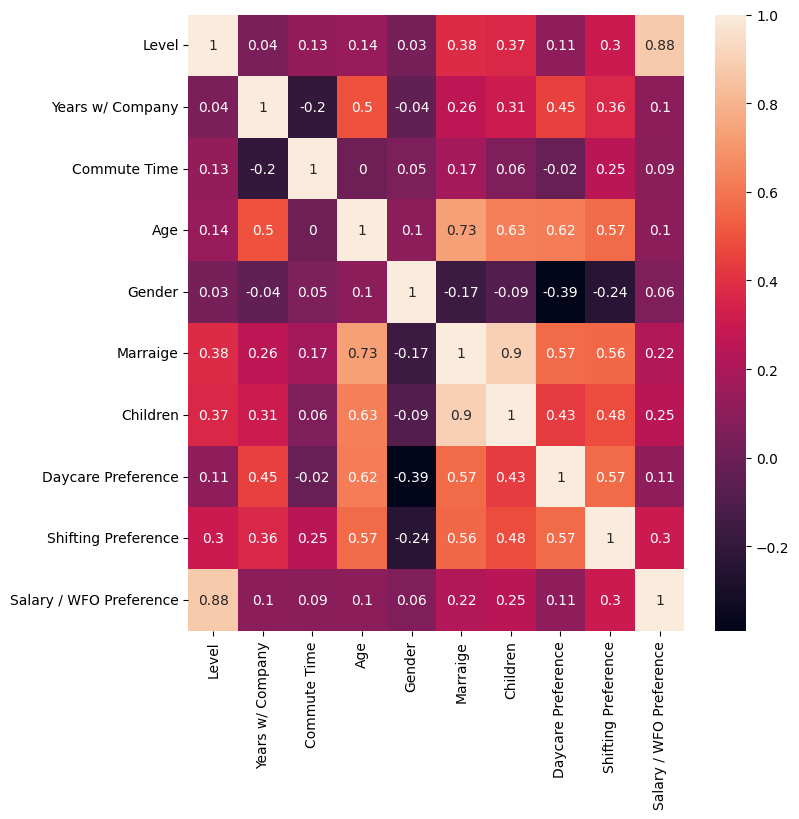

In [40]:
heatmap(num_df)

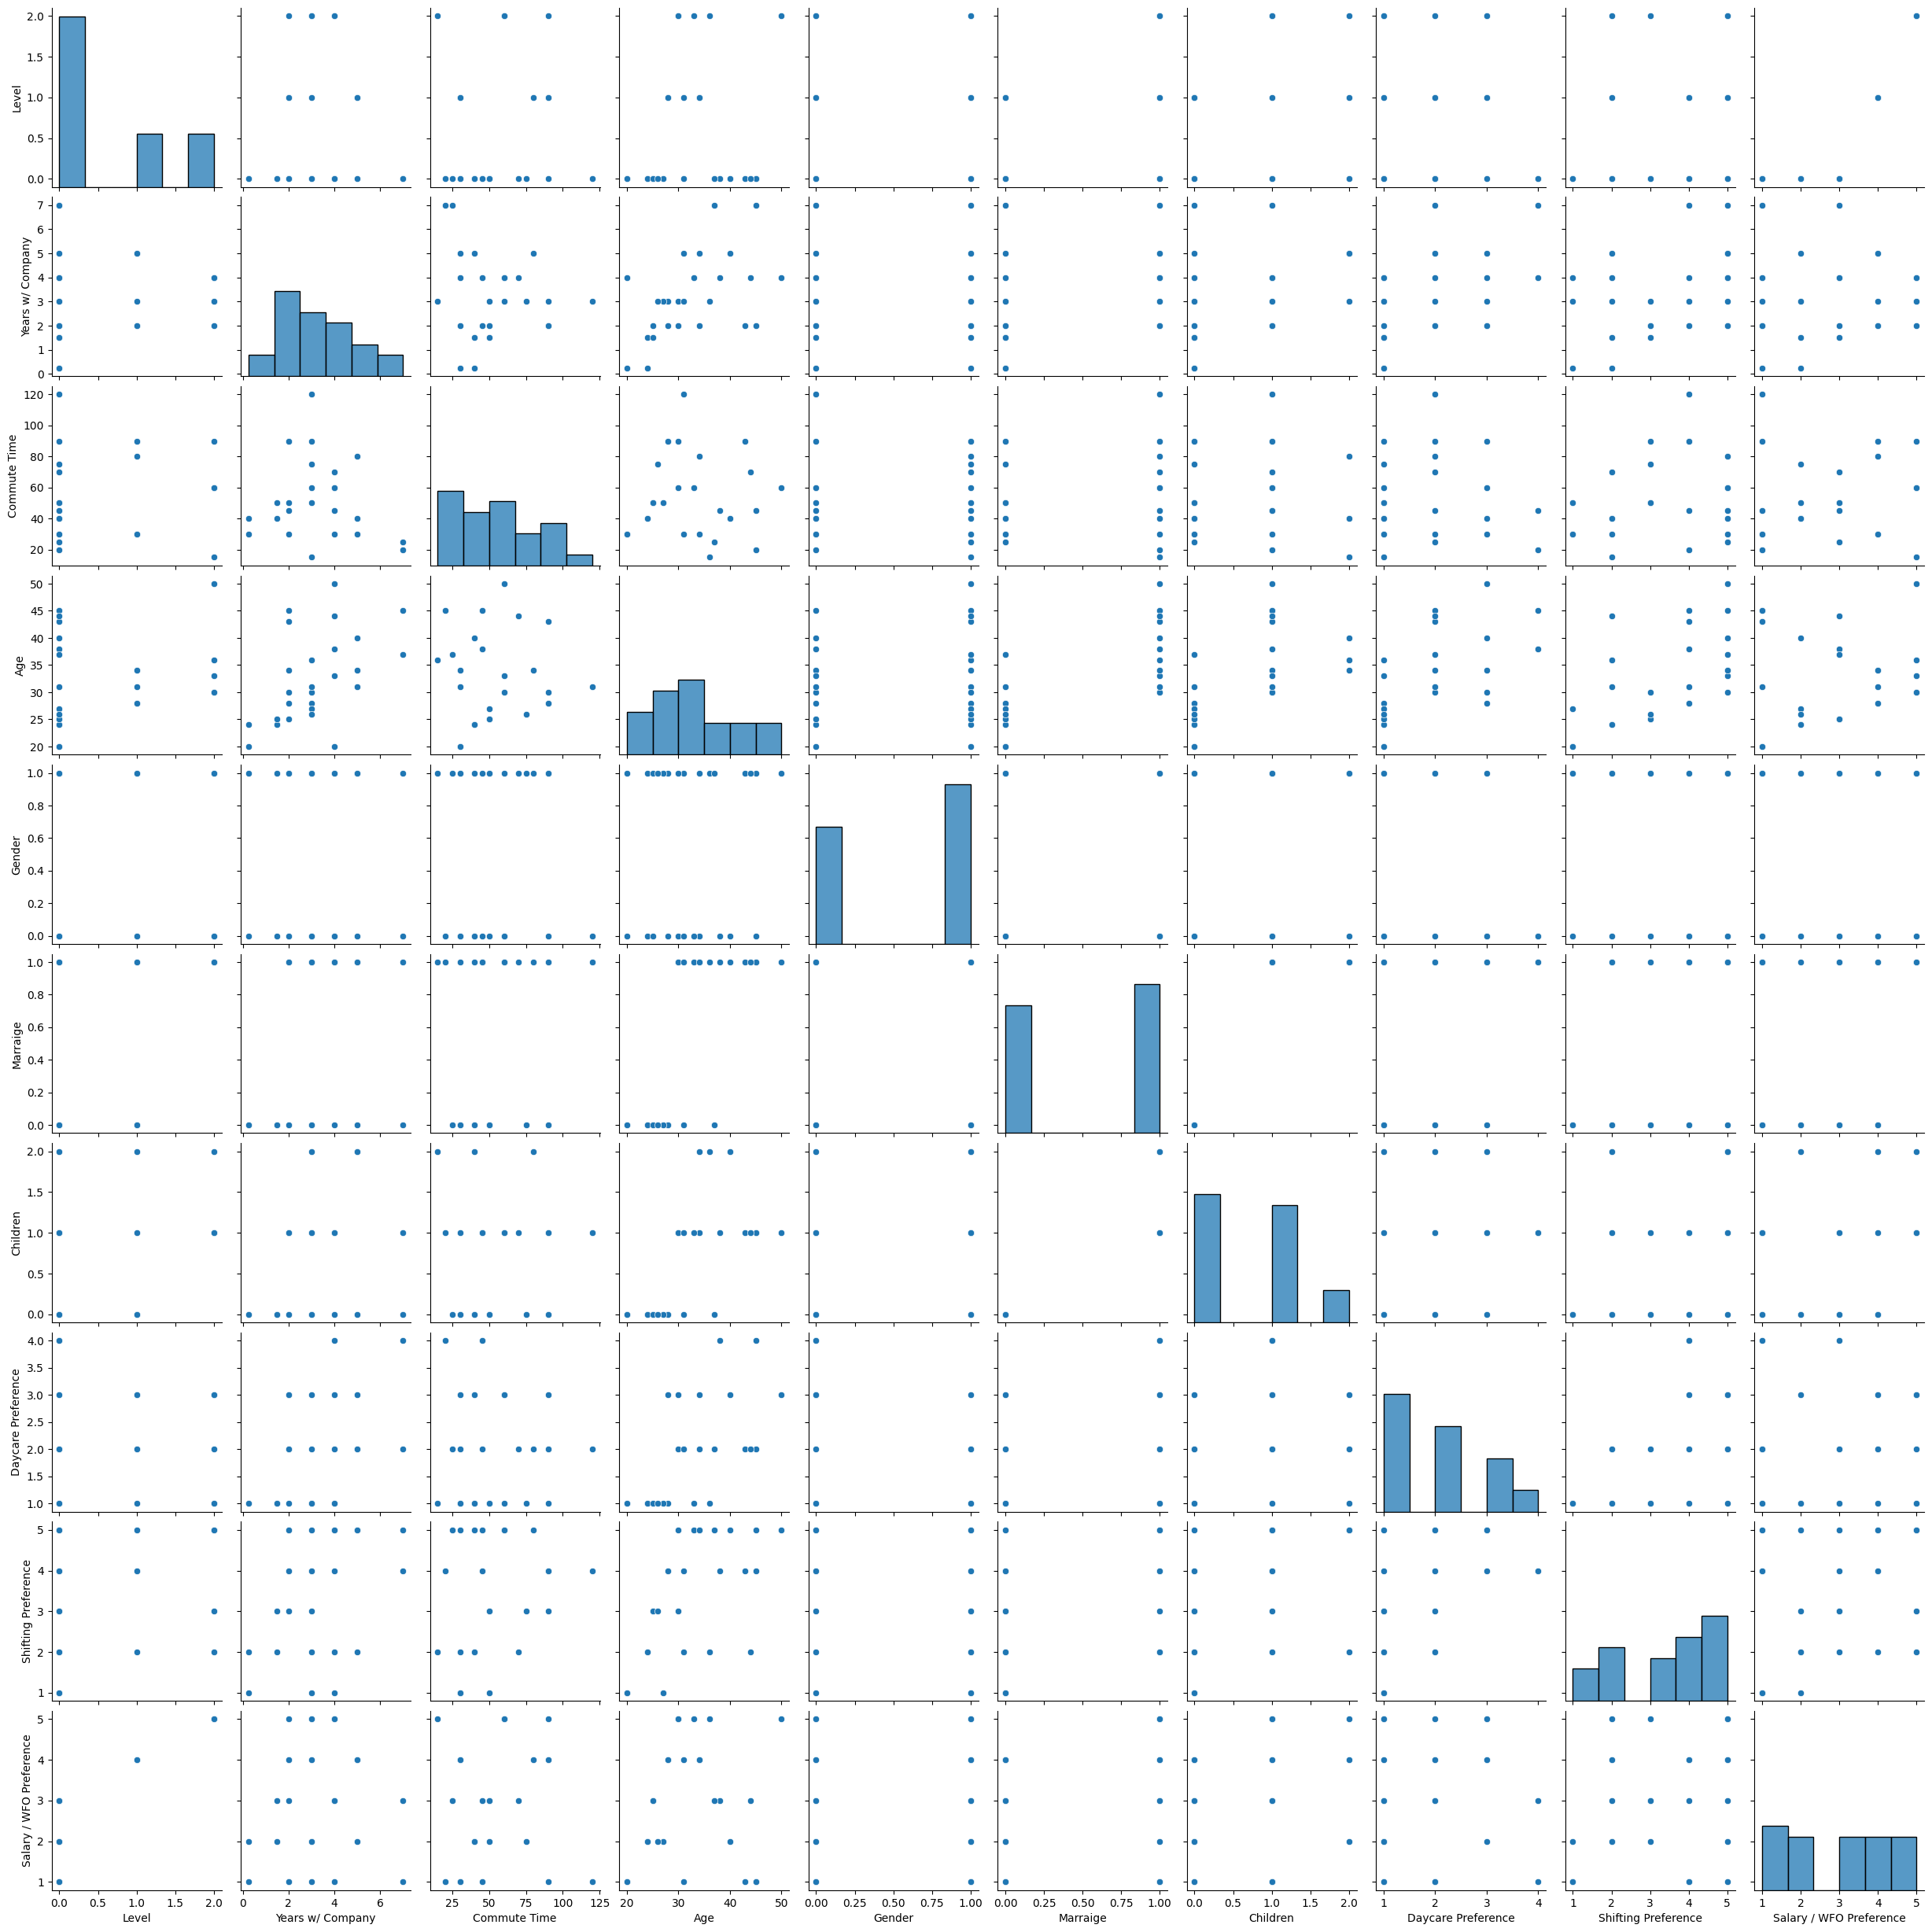

In [41]:
pairplot(num_df)

### Map and Graph tools

In [ ]:
ui = create_employee_map_ui(df, plot_employees)
display(ui)

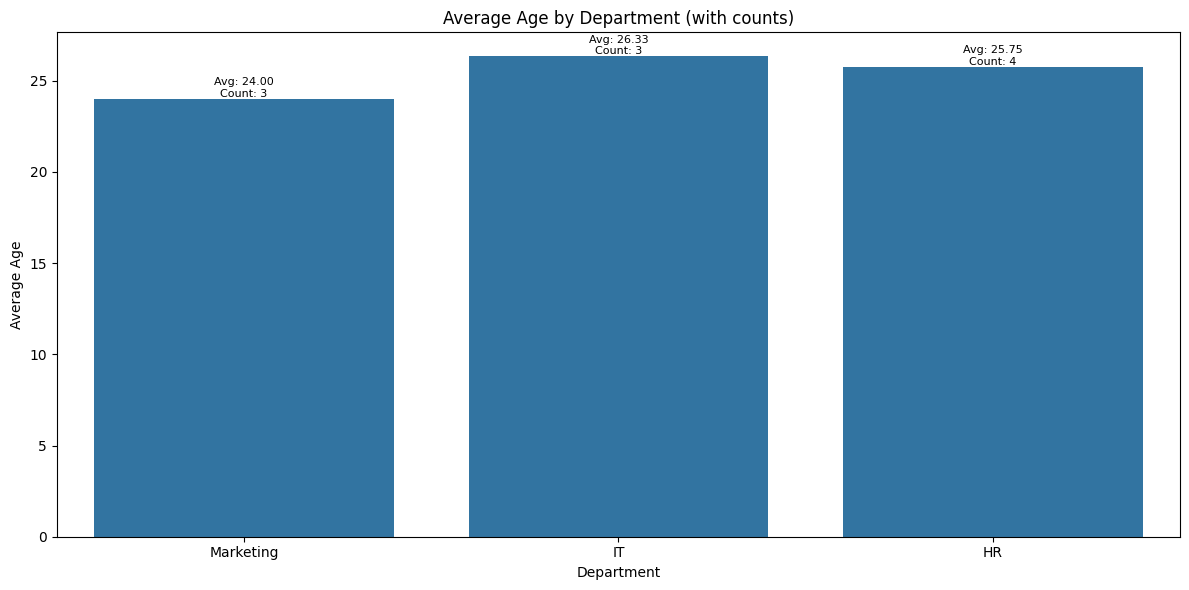

In [ ]:
# see all 22 variables under More Information
categories = "Department"
value = "Age"
make_bargraph(df, categories, value)

## Routing Tools

### Choose Location

In [ ]:
# replace center with copy and pasted office longitude and latitude
points, geocenter = get_points(df)

In [ ]:
route_infos = []

route_infos1 = get_route_infos(df, geocenter)

routes_df1 = create_routes_dataframe(route_infos1)

combined_df1 = pd.concat([df, routes_df1], axis=1)
combined_df1.reset_index(drop=True, inplace=True)

In [ ]:
office = (12.928470681442178, 77.68793393650955)

route_infos2 = []

route_infos2 = get_route_infos(df, office)

routes_df2 = create_routes_dataframe(route_infos2)

combined_df2 = pd.concat([df, routes_df2], axis=1)
combined_df2.reset_index(drop=True, inplace=True)

In [ ]:
first_group = []

for i in range(len(points)):
  if labels[i] == 0:
    first_group.append(points[i])

second_group = []
for i in range(len(points)):
  if labels[i] == 1:
    second_group.append(points[i])


route_infos30 = get_route_infos_from_list(first_group, centroids[0])
route_infos31 = get_route_infos_from_list(second_group, centroids[1])

route_infos3 = route_infos30 + route_infos31
routes_df3 = create_routes_dataframe(route_infos3)

combined_df3 = pd.concat([df, routes_df3], axis=1)
combined_df3.reset_index(drop=True, inplace=True)
combined_df3.head()


,Time,Level,Department,Years w/ Company,Lat and Long,Pincode,Commute Time,Commute Method,Age,Gender,...,Salary / WFO Preference,Managed by Indiqube?,Indiqube Rating,Frequency of app,Usefulness of app,Sentiment,Suggestions,geometry,time,distance
0,7/23/2024 12:30:11,Non executive,Marketing,0.25,"12.929219184155466, 77.62771079999999",NaN,30,Two wheeler EV,20,Man,...,1,No,4,2,1,Flexible,NaN,"{'coordinates': [[77.627586, 12.929233], [77.6...",224.9,2464.9
1,NaN,Non executive,IT,1.50,"12.950795517102389, 77.61704047253774",NaN,40,Two Wheeler EV,24,Man,...,2,Yes,5,4,4,Friendly,NaN,"{'coordinates': [[77.617045, 12.950838], [77.6...",234.5,2348.3
2,NaN,Non executive,HR,2.00,"12.940321422890475, 77.58458798397496",NaN,50,Two Wheeler non EV,25,Man,...,3,Yes,5,4,2,Good,NaN,"{'coordinates': [[77.584548, 12.940322], [77.5...",575.5,6008.1
3,NaN,Mid level executive or manager,Marketing,3.00,"12.904480264661224, 77.60113032392418",NaN,90,Personal Car EV,28,Man,...,4,Yes,4,4,4,NaN,NaN,"{'coordinates': [[77.601125, 12.904641], [77.6...",518.5,6356.6
4,NaN,"Upper level executive, VP, etc.",IT,4.00,"12.964452253042428, 77.647491021871",NaN,60,Personal Car non EV,50,Man,...,5,Yes,4,5,1,Flexible,NaN,"{'coordinates': [[77.647418, 12.964476], [77.6...",425.2,5992.1


### Plot Commute Flower

In [ ]:
route_map1 = create_route_map(routes_df1, geocenter, geocenter, 'clean')
route_map1

In [ ]:
route_map2 = create_route_map(routes_df2, geocenter, office, 'clean')
route_map2

In [ ]:
centroids

array([[12.94169601, 77.62205789],
       [12.95897769, 77.71042185]])

In [ ]:
route_map3 = create_route_map(routes_df3, centroids[0], centroids[1], 'clean')
route_map3

### Commute Analysis

- I spent 90 minutes trying to do error propogation so I could report standard error, but I could not figure out why I was getting such low error margins (like .1%) They should have been much higher.My code is still under the folder.

- Instead, I used the less rigorous max/min estimation of error, defining error margins for each commute method ratio and letting those accumualte to see what the max effect could be if I overestimated or underestimated all of those ratios.

- This does not take into account error in distance.

- The annual factor (I used 50 weeks at 5 days a week with round trip commute each day) and the traffic factor (I used 4 for Bengaluru after research and personal experience) can be set in the function code itself. These values are taken as without error margins.

- The kgs / km ratios and uncertainties can be set in the method code.

- This estimation tool is not nearly as rigorous as I would have liked, but I ran out of time.

In [ ]:
results1 = commute_analysis(combined_df1, 'Geographic Center',4)

In [ ]:
results2 = commute_analysis(combined_df2, 'Corporate Office',4)

In [ ]:
results3 = commute_analysis(combined_df3, "Clustered",4)

In [ ]:
comparison_df = create_the_comparison_df(results1, results2)
comparison_df

,Measure,For Geographic Center,For Corporate Office,Difference
0,total time spend commuting (hours e/ day),46.50,48.74,2.240
1,mean commute time (minutes),53.66,56.24,2.580
2,median commute time (minutes),56.45,60.47,4.020
3,total distance (km a/ day),523.25,525.29,2.040
4,mean commute distance (km),10.06,10.10,0.040
5,median commute distance (km),10.22,10.64,0.420
6,total emissions (kgs e/ year),51783.44,57446.74,5663.300
7,emissions error margin (kgs e/ year),5980.32,6535.61,6257.965


In [ ]:
compare_cluster_df = create_the_comparison_df(results2, results3)
compare_cluster_df

,Measure,For Corporate Office,For Clustered,Difference
0,total time spend commuting (hours e/ day),48.74,29.00,-19.740
1,mean commute time (minutes),56.24,33.46,-22.780
2,median commute time (minutes),60.47,34.09,-26.380
3,total distance (km a/ day),525.29,315.41,-209.880
4,mean commute distance (km),10.10,6.07,-4.030
5,median commute distance (km),10.64,6.20,-4.440
6,total emissions (kgs e/ year),57446.74,32432.94,-25013.800
7,emissions error margin (kgs e/ year),6535.61,3715.84,5125.725


### Location Specific Bar Graphs

In [ ]:
combined_df1 = pd.concat([df, routes_df1], axis=1)
combined_df1.reset_index(drop=True, inplace=True)

In [ ]:
combined_df1

,Time,Level,Department,Years w/ Company,Lat and Long,Pincode,Commute Time,Commute Method,Age,Gender,...,Salary / WFO Preference,Managed by Indiqube?,Indiqube Rating,Frequency of app,Usefulness of app,Sentiment,Suggestions,geometry,time,distance
0,7/23/2024 12:30:11,Non executive,Marketing,0.25,"12.929219184155466, 77.62771079999999",NaN,30,Two wheeler EV,20,Man,...,1,No,4,2,1,Flexible,NaN,"{'coordinates': [[77.627586, 12.929233], [77.6...",655.9,8183.3
1,NaN,Non executive,IT,1.50,"12.950795517102389, 77.61704047253774",NaN,40,Two Wheeler EV,24,Man,...,2,Yes,5,4,4,Friendly,NaN,"{'coordinates': [[77.617045, 12.950838], [77.6...",690.3,8894.3
2,NaN,Non executive,HR,2.00,"12.940321422890475, 77.58458798397496",NaN,50,Two Wheeler non EV,25,Man,...,3,Yes,5,4,2,Good,NaN,"{'coordinates': [[77.584548, 12.940322], [77.5...",1084.5,13604.4
3,NaN,Mid level executive or manager,Marketing,3.00,"12.904480264661224, 77.60113032392418",NaN,90,Personal Car EV,28,Man,...,4,Yes,4,4,4,NaN,NaN,"{'coordinates': [[77.601125, 12.904641], [77.6...",971.6,12616.4
4,NaN,"Upper level executive, VP, etc.",IT,4.00,"12.964452253042428, 77.647491021871",NaN,60,Personal Car non EV,50,Man,...,5,Yes,4,5,1,Flexible,NaN,"{'coordinates': [[77.647418, 12.964476], [77.6...",323.6,3493.8
5,NaN,Non executive,HR,4.00,"12.904766857262652, 77.65055447308434",NaN,30,Bus,20,Woman,...,1,Yes,2,4,2,Friendly,NaN,"{'coordinates': [[77.650554, 12.904767], [77.6...",925.0,12498.2
6,NaN,Non executive,Marketing,0.25,"12.91272292836531, 77.60005875186815",NaN,40,Metro,24,Woman,...,2,Yes,4,5,4,Good,NaN,"{'coordinates': [[77.599973, 12.912723], [77.6...",965.5,12022.3
7,NaN,Non executive,IT,1.50,"12.92160099897878, 77.65574132540011",NaN,50,Auto,25,Woman,...,3,Yes,5,5,4,NaN,NaN,"{'coordinates': [[77.655944, 12.922174], [77.6...",899.2,10895.7
8,NaN,Mid level executive or manager,HR,2.00,"12.965316701154919, 77.60349594776518",NaN,90,"Namma Yatri, Uber, Rapido, etc.",28,Woman,...,4,Yes,5,1,4,Flexible,NaN,"{'coordinates': [[77.603499, 12.965141], [77.6...",794.5,9534.6
9,NaN,"Upper level executive, VP, etc.",HR,3.00,"12.985316701154919, 77.62349594776518",NaN,60,Combination of these,30,Woman,...,5,Yes,5,1,5,Friendly,NaN,"{'coordinates': [[77.623261, 12.984785], [77.6...",604.1,7658.1


In [ ]:
## see all 22 variables under More Information, plus time and distance values in the combined_df
# categories = "Department"
# value = "Age"
# for_title = "Geographic Center"
# make_bargraph_for_this_center(combined_df1, categories , value, for_title)

In [ ]:
# prompt: multiply each entry of time column of df by x, return new df
def multiply_time_column(df, x):
  df_copy = df.copy()  # Create a copy to avoid modifying the original DataFrame
  df_copy['time'] = df_copy['time'] * x / 60
  return df_copy

In [ ]:
traffic_multiplier = 4
df_to_show = multiply_time_column(combined_df1, traffic_multiplier)

In [ ]:
interactive_bargraph(df_to_show)

## Clustering Tools

### Center of Mass by Category

In [ ]:
coms_map = plot_by_category(df, "Level", geocenter, 12, 'clean')
coms_map

### K-Means

In [ ]:
labels, centroids = Kmeans(points)
cluster_map = plot_clusters(points, geocenter, labels, centroids,'clean')
cluster_map

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Weighted K-Means

In [ ]:
numeric = non_drop_numeric(df)
weights = list(numeric['Age'])

n_clusters = 3
max_iterations = 5
n_repetitions = 5

labels, centroids = claudes_weighted_kmeans(points,weights,n_clusters, max_iterations, n_repetitions, standard_distance)
cluster_map = plot_clusters(points, geocenter, labels, centroids,'clean')
cluster_map

In [ ]:
labels[0]

0

# More Information and Tests

## About the data

I suggest converting some of the categorical data to numerical, meaning level could be 0, 1, 3 and marragie could be 0 for No and 1 for Yes, similiar for gender, this would allow graphing these things, as we do with num_df

```
Column Names

Index -- Feature Name
0,Time
1,Level
2,Department
3,Years w/ Company
4,Lat and Long
5,Pincode
6,Commute Time
7,Commute Method
8,Age
9,Gender
10,Marraige
11,Children
12,Residence
13,Daycare Preference
14,Shifting Preference
15,Pincode Preference
16,Salary / WFO Preference
```


```
Survey Questions:

Timestamp
Level
What department are you in?
"How many years have you been with the company? For more detail, please use decimals. For example 3.5 (no need to write years). "
Latitude and Longitude
What is you pincode? (optional)
"How long, in minutes, is your current commute on average? Please enter only numbers"
How do you commute?
What is your age?
What is your gender?
Are you married?
How many children do you have?
Which do you live in?
Is having daycares / schools near your office important to you?  
"If your office considered shifting, would you like to stay living where you are? "
Please enter the pincode of where you would like to live (optional)
Would you prefer salary raises or more work from home option?


```


## Tests

### Test OSRM requests

In [ ]:
# TEST 2 points
# SWITCH LONG AND LAT
# Test Requests are working. The time between these 2 points should be 683.4 seconds
# This route took us over an hour this morning though becuase of traffic
## this shouldn't take more than a few seconds to run
import requests
import folium

waypoints_str = '77.62771079999999,12.929219184155466;77.68594224954005,12.93188453816586'

url = f"http://router.project-osrm.org/route/v1/driving/{waypoints_str}?geometries=geojson"


  # Make the request
response = requests.get(url)
if response.status_code != 200:
     raise Exception(f"Error: Received response code {response.status_code} from OSRM server")

data = response.json()

  # Extract the route duration
if 'routes' in data:
      routeinfo = data['routes']
      if routeinfo and 'geometry' in routeinfo[0]:
          time = routeinfo[0]['duration']
          geometry = routeinfo[0]['geometry']
          distance = routeinfo[0]['distance']

      else:
          print("These locations might be seperated by an ocean")
else:
      print("OSRM may be having problems returning any information")

print("duration: " +  str(time))
print("distance: " + str(distance))
routes = []
routes.append(geometry['coordinates'])
map = folium.Map(location=(12.929219184155466,77.62771079999999), zoom_start=10)
map = add_routes(map,routes, "blue")
map

duration: 683.4
distance: 7646.5


## Other Notes


about route_infos


- route_infos is an ordered list of dicts, each with geometry, time, and dist

- to access the latitude of the second point in the third route:


- routes_df['geometry'][2]['coordinates'][1][0]